# Convergence study

- Experimental setup: 
    - rest length s=1.0
    - we parametrize the force functions such that the relaxation time is 1.0h (If we have time we can study the effect of the force function parameters on the convergence.)
    - adhesion
        - initial distance of 1.35 (we need to study the influence of the initial distance!)
- Force laws we consider
    - linear (only for repulsion)
    - cubic
    - piecewise quadratic
- solvers
    - RK45 from scipy
    - EF (own implementation)
- Plots
    - l2-norm of the difference of the cell-cell distance between two successive time step values as a function of the number of timesteps.
    - (Alternatively we could plot the error to a reference solution as a function of the number of time steps. Then we would need to make sure that the reference solution is good enough.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
from scipy.interpolate import CubicSpline

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'font.size': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 3.0  # final time
rA = 1.5   # maximum interaction distance

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
muGLS = 1.95
params_gls = {'mu': muGLS, 'a':-2*np.log(0.002/muGLS)}
#params_gls = {'mu': 3.84, 'a':5}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [3]:
solver_names = ['EF', 'AB', 'midpoint', 'Heun']
force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[1], 'GLS': defcolors[3]}

In [4]:
# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, 1)}
solvers_ab = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ab.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, ab.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, ab.solve_ivp, 1)}
solvers_he = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, he.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, he.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, he.solve_ivp, 1)}
solvers_md = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, md.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, md.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, md.solve_ivp, 1)}
solver_dicts = {'EF': solvers_ef, 'AB': solvers_ab, 'midpoint': solvers_md}

In [5]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=True), cl.Cell(1, [1.15], proliferating=True)]

## Reference solution

In [6]:
dt_ref = 0.0001
N_ref = int(1/dt_ref*tf)+1
t_data_ref = np.linspace(0, tf, N_ref)

ref_sol_dicts = {}
for solver in solver_names:
    print('>'+solver)
    solvers = solver_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        print('>>'+force)
        history = solvers[force].simulate(cell_list, t_data_ref, params[force], {'dt': dt_ref})
        ref_sols[force] = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])[:len(t_data_ref)]
    ref_sol_dicts[solver] = ref_sols    

>EF
>>cubic
>>pw. quad.
>>GLS
>AB
>>cubic
>>pw. quad.
>>GLS
>midpoint
>>cubic
>>pw. quad.
>>GLS
>Heun
>>cubic
>>pw. quad.
>>GLS


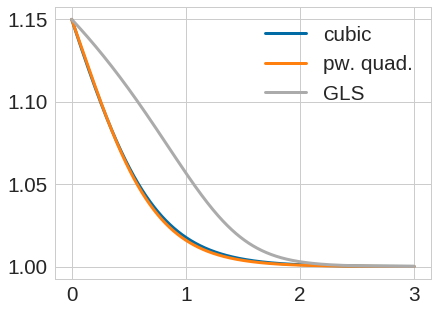

In [7]:
# plot the reference solution
for force in force_names:
    plt.plot(t_data_ref, ref_sol_dicts['AB'][force], label=force)
    plt.legend()

In [8]:
# let's check the scipy solver
solvers_scipy = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, scpi.solve_ivp, 1)}

In [9]:
ref_sol_scipy = {}
for force in force_names: 
    history = solvers_scipy[force].simulate(cell_list, t_data_ref, params[force], {})
    ref_sol_scipy[force] = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])[:len(t_data_ref)]


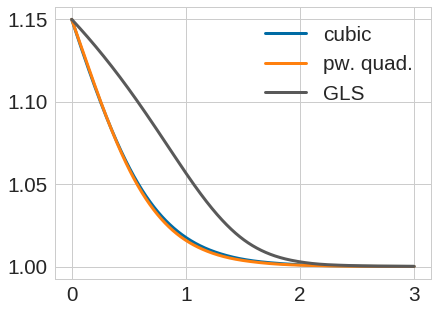

In [10]:
# plot the reference solution
for force in force_names:
    plt.plot(t_data_ref, ref_sol_scipy[force], label=force, color=colors[force])
    plt.legend()

In [11]:
dt_values = [0.001*1.25**n for n in range(0, 22)]
sol_dicts = {}

In [12]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        history = solver_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt})
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EF'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['EF'] = sol


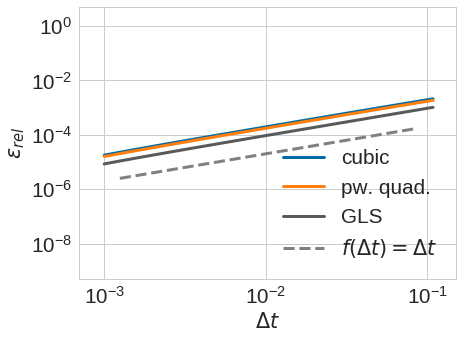

In [13]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['EF'][force], label=force, color=colors[force])
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.002, '--', label='$f(\Delta t)=\Delta t$', color='grey')
plt.legend()
#plt.title('Euler forward')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])

plt.savefig('adhesion_convergence_ef.pdf', bbox_inches='tight')



In [14]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        history = solver_dicts['midpoint'][force].simulate(cell_list, t_data, params[force], {'dt': dt})
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        spline = CubicSpline(t_data[:length], np.squeeze(y[:length]))
        #inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        inter = spline(t_data_ref)
        ref = np.squeeze(ref_sol_dicts['midpoint'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['midpoint'] = sol

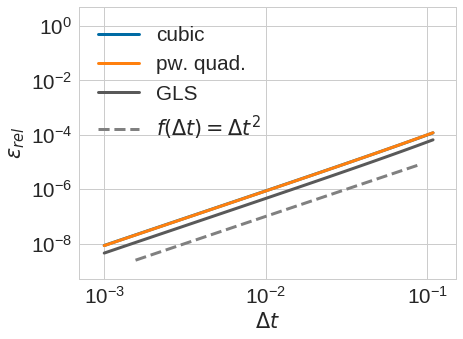

In [15]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['midpoint'][force], label=force, color=colors[force])
plt.loglog(dt_values[2:-1], np.array(dt_values[2:-1])**2*0.001, '--', label='$f(\Delta t)=\Delta t^2$', color='grey')
plt.legend()
#plt.title('Midpoint')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])

plt.savefig('adhesion_convergence_md.pdf', bbox_inches='tight')

In [16]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        history = solver_dicts['AB'][force].simulate(cell_list, t_data, params[force], {'dt': dt})
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['AB'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['AB'] = sol

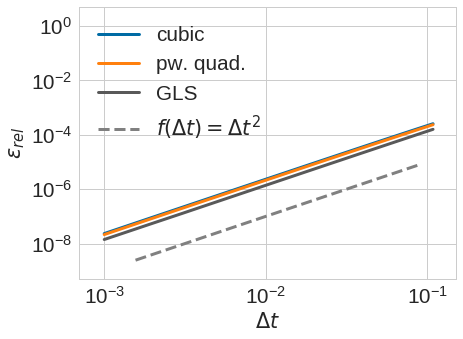

In [17]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['AB'][force], label=force, color=colors[force])
plt.loglog(dt_values[2:-1], np.array(dt_values[2:-1])**2*0.001, '--', label='$f(\Delta t)=\Delta t^2$', color='grey')
plt.legend()
#plt.title('Adams-Bashforth')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])

plt.savefig('adhesion_convergence_ab.pdf', bbox_inches='tight')

## Plot all in one figure

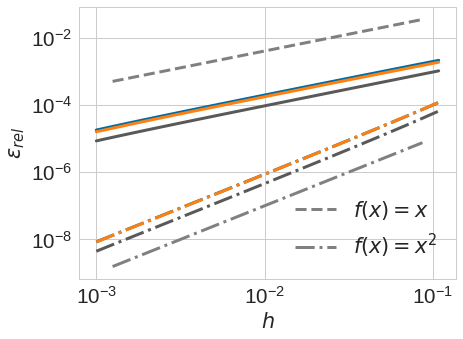

In [18]:
linestyles = {'EF' : '-', 'midpoint': '-.' }
for solver in ['EF', 'midpoint']:
    for force in force_names: 
        plt.loglog(dt_values, sol_dicts[solver][force], color=colors[force], linestyle=linestyles[solver])

plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.4, '--', label='$f(x)=x$', color='grey')
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])**2*0.001, '-.', label='$f(x)=x^2$', color='grey')
plt.legend()
plt.xlabel('$h$')
plt.ylabel('$\epsilon_{rel}$')
plt.savefig('adhesion_convergence_pwq_cubic_gls_ef_md.pdf', bbox_inches='tight')